In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# Uplopading CheckM results (reference Spirochaetes)
order = pd.read_csv("bin_stats_ext_order.csv")

In [3]:
# Uploading CheckM results (reference Bacteria)
gen_check = pd.read_csv("Check_m_output.csv")

In [4]:
order.head()

,ID,Marker Lineage,# Genomes,# Markers,# Marker Sets,0,1,2,3,4,...,# contigs,Longest scaffold,Longest contig,N50 (scaffolds),N50 (contigs),Mean scaffold length,Mean contig length,Coding density,Translation table,# predicted genes
0,M1080786199,Spirochaetales,71,218,127,96,122,0,0,0,...,18,230568,230568,122932,122932,68900.777778,68900.777778,0.940234,11,1123
1,M1126320974,Spirochaetales,71,218,127,47,168,3,0,0,...,492,14011,14011,3951,3951,3435.227642,3435.227642,0.938589,11,1911
2,M1145915061,Spirochaetales,71,218,127,0,216,2,0,0,...,249,63290,63290,14860,14860,9092.538153,9092.538153,0.939913,11,2195
3,M1026938161,Spirochaetales,71,218,127,1,216,1,0,0,...,65,141078,141078,62499,62499,34929.600000,34929.600000,0.943382,11,2051
4,M1150682003,Spirochaetales,71,218,127,1,217,0,0,0,...,158,54589,54589,23081,23081,13999.721519,13999.721519,0.941280,11,2059


In [5]:
order[['ID', 'Completeness', 'Contamination']].head()

,ID,Completeness,Contamination
0,M1080786199,59.842520,0.000000
1,M1126320974,74.407905,1.968504
2,M1145915061,100.000000,0.833719
3,M1026938161,99.212598,0.026247
4,M1150682003,99.212598,0.000000


In [6]:
gen_check[['ID', 'Completeness', 'Contamination']].head()

,ID,Completeness,Contamination
0,M1080786199,60.344828,0.000000
1,M1126320974,69.174504,1.724138
2,M1145915061,92.241379,2.298851
3,M1026938161,93.965517,0.000000
4,M1150682003,93.965517,0.000000


In [7]:
# Function for categrizing the quality of the bins
def categorize_quality(df):
    def get_quality(row):
        if row['Completeness'] >= 90 and row['Contamination'] <= 5:
            return 'High'
        elif 50 <= row['Completeness'] < 90 and row['Contamination'] <= 5:
            return 'Medium'
        else:
            return 'Low'

    # Apply the function to the dataframe
    df['Quality_pred'] = df.apply(get_quality, axis=1)
    return df

In [8]:
# Categorizing the quality of the bins
gen_check_pred = categorize_quality(gen_check)
order_pred = categorize_quality(order)
# Trimming the dataframes and merging them
gen_pred_short = gen_check_pred[['ID', 'Quality_pred']]
order_pred_short = order_pred[['ID','Quality_pred']]
merged = pd.merge(gen_pred_short, order_pred_short, on='ID', suffixes=('_gen', '_order'))
merged.head()

,ID,Quality_pred_gen,Quality_pred_order
0,M1080786199,Medium,Medium
1,M1126320974,Medium,Medium
2,M1145915061,High,High
3,M1026938161,High,High
4,M1150682003,High,High


In [9]:
# Creating a table with the quality differences
diff = merged[merged['Quality_pred_gen'] != merged['Quality_pred_order']]
diff = diff.rename(columns={'Quality_pred_gen': 'Quality (reference Bacteria)', 'Quality_pred_order': 'Quality (reference Spirochaetales)'})
# conditional coloring
def quality_color(val):
    colors = []
    text_colors = []
    for v in val:
        if v == 'Low':
            colors.append('black')
            text_colors.append('white')
        elif v == 'Medium':
            colors.append('gray')
            text_colors.append('black')
        else:
            colors.append('white')
            text_colors.append('black')
    return ['background-color: %s; color: %s' % (color, text_color) for color, text_color in zip(colors, text_colors)]
# Applying the coloring
diff = diff.style.apply(quality_color, axis=1, subset=['Quality (reference Bacteria)', 'Quality (reference Spirochaetales)']).set_caption('Quality differences between reference Bacteria and Spirochaetales')
diff

,ID,Quality (reference Bacteria),Quality (reference Spirochaetales)
7,M1209946257,Medium,High
12,M1315560073,Medium,High
15,M1357088918,Medium,High
18,M1572548456,Medium,High
20,M1730638125,Low,Medium
28,M1973003636,Medium,High


In [10]:
qal = order_pred[['ID', 'Completeness', 'Contamination', 'Quality_pred']]
qal = qal.rename(columns={'Quality_pred': 'Quality'})
# setting index from 1
qal.index = qal.index + 1
# adding title "Quality assessment of MAGs"
qal = qal.style.set_caption('Quality assessment of MAGs (reference Spirochaetales)')

# Applying gradient and quality color
qal = qal.background_gradient(cmap='gray_r', subset=['Contamination'])
qal = qal.background_gradient(cmap='gray', subset=['Completeness'])
qal.apply(quality_color, subset=['Quality'])


,ID,Completeness,Contamination,Quality
1,M1080786199,59.842520,0.000000,Medium
2,M1126320974,74.407905,1.968504,Medium
3,M1145915061,100.000000,0.833719,High
4,M1026938161,99.212598,0.026247,High
5,M1150682003,99.212598,0.000000,High
6,M1195283575,100.000000,0.000000,High
7,M1201267653,92.624672,2.670990,High
8,M1209946257,92.913386,0.000000,High
9,M1212061447,100.000000,0.787402,High
10,M1236472425,96.981627,0.787402,High


In [11]:
import dataframe_image as dfi
dfi.export(qal, 'order.png')
dfi.export(diff, 'diff.png')

In [12]:
# Uploading PhyloPhlAn results
phil = pd.read_table("/home/vlad/drive2/jupyter/MicGen/project/SGB3587-20240326T084819Z-001/SGB3587/ppa_m.tsv", sep=r'[:\t]')
phil = phil.rename(columns={'#input_bin': 'ID', 'avg_dist': 'Average distance'})

/home/vlad/drive2/micromamba/envs/dfimg/lib/python3.6/site-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


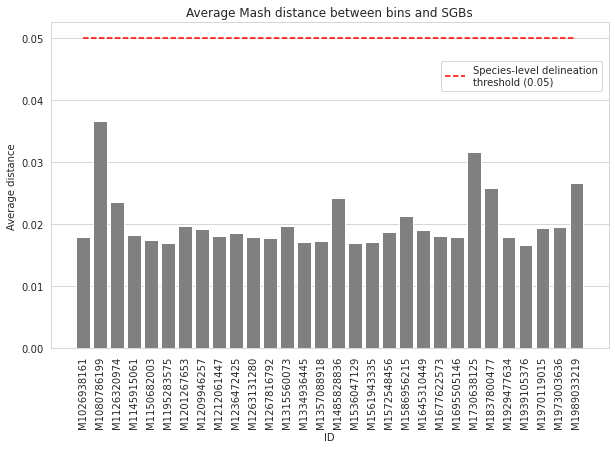

In [13]:
import matplotlib.pyplot as plt
# Barplot with the average distances
fig = plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='ID', y="Average distance", data=phil, color='grey')
ax.title.set_text('Average Mash distance between bins and SGBs')    
ax.tick_params(axis='x', rotation=90)
ax.hlines(0.05, xmin=0, xmax=29, colors='r', linestyles='dashed', label='Species-level delineation\nthreshold (0.05)')
ax.legend(loc=[0.7, 0.79])
# save the figure with vertical x-axis labels, dpi=300
plt.savefig('avg_dist.png', dpi=300, bbox_inches='tight')